In [1]:
import datetime
import json
from pathlib import Path, PosixPath

import numpy as np
import pandas as pd

from mapping import MAPPING

In [2]:
DATA = Path.cwd() / 'csvs'

In [3]:
def add_id(fac_name: str) -> str:
    s = MAPPING.get(fac_name)
    return str(s) if s is not None else None

def parse_path_date(p: PosixPath) -> datetime.datetime:
    s = p.name.replace('tabula-', '').replace('.csv', '')
    year, month = s.split('-')
    
    return datetime.datetime(int(year), int(month), 1)

In [4]:
def parse_file(p: PosixPath) -> pd.DataFrame:
    dt = parse_path_date(p)

    # snapshot_date is the beginning of the next month
    month = dt.month + 1 if dt.month < 12 else 1
    year = dt.year if abs(dt.month - month) == 1 else dt.year + 1
    date_str = datetime.datetime(year, month, 1).strftime('%Y-%m-%d')

    col_names = {
        'Detention Facility Name': 'facility',
        'Facility Name': 'facility',

        'Average Daily Population': 'total',
        'Daily Population': 'total',

        'Number Felony Pretrial': 'felony_pretrial',
        'Felony Pretrial': 'felony_pretrial',

        'Number Misdemeanor Pretrial': 'misdemeanor_pretrial',
        'Misdemeanor Pretrial': 'misdemeanor_pretrial',
    }

    df = pd.read_csv(p, on_bad_lines='skip')
    df.columns = [c.replace('\r', ' ') for c in df.columns]

    df = df.rename(columns=col_names)
    
    # drop completely blank cols and rows
    df = df.dropna(how='all', axis=1)
    df = df.dropna(how='all', axis=0)

    # remove total, grand total, and duplicate header rows
    df = df[~(df['facility'].str.startswith('Detention', na=False))]
    df = df[~(df['facility'].str.startswith('Total', na=False))]
    df = df[~(df['facility'].str.startswith('Grand Total', na=False))]

    # remove blank facilities
    df = df.dropna(subset='facility')

    # convert num columns to int
    for col in ['total', 'felony_pretrial', 'misdemeanor_pretrial']:
        df[col] = df[col].str.replace('*', '', regex=False).str.replace(',', '').replace('-', np.nan)
        df = df.dropna(subset=col)
        df[col] = df[col].astype(int)

    # add id
    df['id'] = df['facility'].apply(add_id)
    df = df.dropna(subset=['id'])

    # add snapshot_date from file name
    df['year_month'] = dt.strftime('%Y-%m')
    df['snapshot_date'] = date_str

    # add col
    df['detained_or_awaiting_trial'] = df['felony_pretrial'] + df['misdemeanor_pretrial']

    # finalize columns
    df = df[['id', 'snapshot_date', 'year_month', 'detained_or_awaiting_trial', 'total']]

    return df

In [5]:
# mapping of YYYY-MM -> pdf url
with open('url_mapping.json') as f:
    url_mapping = json.load(f)

In [6]:
df = pd.concat([parse_file(f) for f in DATA.glob('*.csv')])

# make sure the numbers line up
assert (df['detained_or_awaiting_trial'] > df['total']).sum() == 0
assert (df['total'] == 0).sum() == 0

# add source url
df['source_url'] = 'http://www.dc.state.fl.us/pub/jails/index.html'
assert (df['source_url'].isnull()).sum() == 0

# add source_url_2
df['source_url_2'] = df['year_month'].apply(lambda s: url_mapping.get(s))
assert (df['source_url_2'].isnull()).sum() == 0

len(df)

3105

In [7]:
df.head()

,id,snapshot_date,year_month,detained_or_awaiting_trial,total,source_url,source_url_2
0,6830,2021-10-01,2021-09,527,743,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
3,6923,2021-10-01,2021-09,1068,1286,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
4,6833,2021-10-01,2021-09,83,157,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
5,6834,2021-10-01,2021-09,1309,1519,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
6,6837,2021-10-01,2021-09,1151,1251,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...


## plot random facility as a spot check

6854
Escambia County Central Booking


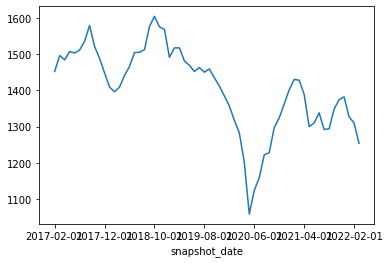

In [8]:
rand_fac = df['id'].sample().values[0]
print(rand_fac)
print({v: k for k,v in MAPPING.items()}.get(int(rand_fac)))

df[df['id'] == rand_fac].set_index(['snapshot_date']).sort_index()['total'].plot();

## export

In [9]:
df.head()

,id,snapshot_date,year_month,detained_or_awaiting_trial,total,source_url,source_url_2
0,6830,2021-10-01,2021-09,527,743,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
3,6923,2021-10-01,2021-09,1068,1286,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
4,6833,2021-10-01,2021-09,83,157,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
5,6834,2021-10-01,2021-09,1309,1519,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...
6,6837,2021-10-01,2021-09,1151,1251,http://www.dc.state.fl.us/pub/jails/index.html,http://www.dc.state.fl.us/pub/jails/2021/jails...


In [10]:
output_cols = ['id', 'snapshot_date', 'detained_or_awaiting_trial', 'total', 'source_url', 'source_url_2']

df[output_cols].to_csv('inmate_population_snapshots.csv', index=False)